In [6]:
# Setup for the notebook
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import nengo
import nengo_spa as spa

# functions: 
# find the names of the most active S-pointers and print them into the figure at the place of highest value:
# find name, max_similarity and t_max for n_sps most active semantic pointers for a nengo-buffer (buff-name)
# sim_data of nengo buffer need to be copied in numpy-array buff_simdata for faster processing
def most_active_SPs(keys, n_sps, buff_simdata):
 #print (buff_name, ':')
 # keys = list(module.vocab.keys())
 sp_len = len(keys)
 #print ('amount of SPointers = ', sp_len) 

 max_val = [-1.0] * sp_len
 name_sp = [''] * sp_len
 t_max   = [0] * sp_len
 sp_list = []
 splist_tmax = []
 splist_ymax = []
 splist_name = []   
 for sp in range(0, sp_len):
    sp_list.append(sp)
 # search max_val for all sp's and transfer name, max_val and t_max to lists 
 for sp in sp_list:
    name_sp[sp] = keys[sp]
    for t in range(0, time_msec):
        if buff_simdata[t][sp] > max_val[sp]:
            max_val[sp] = buff_simdata[t][sp]
            t_max[sp] = t
 # find n SPointer with highest similarity values 
 n = n_sps
 for i in range(0, n):
    curr_max_val = -1.0
    for sp in sp_list:
        if sp > -1:
            if max_val[sp] > curr_max_val:
                curr_max_val = max_val[sp]
                curr_t_max = t_max[sp]
                sp_max_nr = sp
    # sp with max similarity value:    
    #print (name_sp[sp_max_nr]) 
    #print ('max_similarity: ', curr_max_val, '; at time in msec: ', curr_t_max)
    splist_tmax.append(curr_t_max/1000.)
    splist_ymax.append(curr_max_val)
    splist_name.append(name_sp[sp_max_nr])   
    # change sp_list
    sp_list[sp_max_nr] = -1
 return (splist_tmax, splist_ymax, splist_name)


In [7]:
# Creae the model

# Number of dimensions for the SPs
dimensions = 64

# vocab: 
vocab_ex = spa.Vocabulary(dimensions=dimensions)  # syntax marker, words, wcats, products of synt marker, products of all with words  
vocab_word = spa.Vocabulary(dimensions=dimensions)
vocab_part_tree = spa.Vocabulary(dimensions=dimensions)
vocab_wcat_word = spa.Vocabulary(dimensions=dimensions)

# words 
words =         ['THE', 'A', 'MANY', 'DOG', 'DOGS', 'CAT', 'CATS', 'RUN', 'CHASES', 'CHASE', 'RAN', 'IS', 'ARE', 'RUNNING', 'CHASING', 'EMPTY', 'W_PHRA_END']
wcat_keys =     ['DET', 'DET', 'PRON', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'VERB', 'VERB', 'VERB', 'VERB', 'AUXV', 'AUXV', 'VERB', 'VERB', 'EMPTY', 'WCAT_00']
vocab_word.populate(';'.join(words)) 
word_keys = vocab_word.keys()  # müssen genau zu den wcat_keys passen!!!!

# word categories -> is as well a part of vocab_smark!!!
word_categories = ['DET', 'PRON', 'NOUN', 'VERB', 'AUXV', 'WCAT_00']

# syntax marker
syntax_marker = ['CLAUSE_L', 'CLAUSE_R', 'NOUN_PHRA_L', 'NOUN_PHRA_R', 'VERB_PHRA_L', 'VERB_PHRA_R']

vocab_ex.populate(';'.join(words))
vocab_ex.populate(';'.join(word_categories))
vocab_ex.populate(';'.join(syntax_marker))
vocab_ex.populate('CL_NPL_D = CLAUSE_L * NOUN_PHRA_L * DET; CL_NPR_N = CLAUSE_L * NOUN_PHRA_R * NOUN; CL_NPL_N = CLAUSE_L * NOUN_PHRA_L * NOUN;' +   # die Allgemeinen
                  'CR_VPL_V = CLAUSE_R * VERB_PHRA_L * VERB; CR_NPL_D = CLAUSE_R * NOUN_PHRA_L * DET;' +
                  'CR_NPR_N = CLAUSE_R * NOUN_PHRA_R * NOUN; CR_NPL_N = CLAUSE_R * NOUN_PHRA_L * NOUN;' +  
                  'CR_VPR_V = CLAUSE_R * VERB_PHRA_R * VERB; CR_VPL_AV = CLAUSE_R * VERB_PHRA_L * AUXV;' +
                  'DET_THE = DET * THE; DET_A = DET * A; NOUN_DOG = NOUN * DOG; NOUN_CAT = NOUN * CAT; VERB_CHASES = VERB * CHASES;' +       # die Satz-Spezifischen wcat_word-Kombinationen
                  'NOUN_DOGS = NOUN * DOGS; NOUN_CATS = NOUN * CATS; VERB_CHASE = VERB * CHASE; VERB_RAN = VERB * RAN; AUXV_ARE = AUXV * ARE; AUXV_IS = AUXV * IS;' +
                  'VERB_RUNNING = VERB * RUNNING; VERB_CHASING = VERB * CHASING;' +
                  'THE_DOG_CHASES = CLAUSE_L * NOUN_PHRA_L * DET * THE + CLAUSE_L * NOUN_PHRA_R * NOUN * DOG + CLAUSE_R * VERB_PHRA_L * VERB * CHASES;' +     # ganze Sätze 
                  'DOGS_CHASE = CLAUSE_L * NOUN_PHRA_L * NOUN * DOGS + CLAUSE_R * VERB_PHRA_L * VERB * CHASE;' + 
                  'THE_DOG_CHASES_A_CAT = CLAUSE_L * NOUN_PHRA_L * DET * THE + CLAUSE_L * NOUN_PHRA_R * NOUN * DOG + CLAUSE_R * VERB_PHRA_L * VERB * CHASES' 
                  ' + CLAUSE_R * NOUN_PHRA_L * DET * A + CLAUSE_R * NOUN_PHRA_R * NOUN * CAT;' +
                  'THE_DOG_CHASES_CATS = CLAUSE_L * NOUN_PHRA_L * DET * THE + CLAUSE_L * NOUN_PHRA_R * NOUN * DOG + CLAUSE_R * VERB_PHRA_L * VERB * CHASES' 
                  ' + CLAUSE_R * NOUN_PHRA_L * NOUN * CATS;' +   
                  'DOGS_CHASE_CATS = CLAUSE_L * NOUN_PHRA_L * NOUN * DOGS + CLAUSE_R * VERB_PHRA_L * VERB * CHASE + CLAUSE_R * NOUN_PHRA_L * NOUN * CATS;' + 
                  'DOGS_CHASE_A_CAT = CLAUSE_L * NOUN_PHRA_L * NOUN * DOGS + CLAUSE_R * VERB_PHRA_L * VERB * CHASE' 
                  ' + CLAUSE_R * NOUN_PHRA_L * DET * A + CLAUSE_R * NOUN_PHRA_R * NOUN * CAT;' + 
                  'THE_DOG_IS_CHASING = CLAUSE_L * NOUN_PHRA_L * DET * THE + CLAUSE_L * NOUN_PHRA_R * NOUN * DOG + CLAUSE_R * VERB_PHRA_L * AUXV * IS'
                  ' + CLAUSE_R * VERB_PHRA_R * VERB * CHASING;' + 
                  'DOGS_ARE_CHASING = CLAUSE_L * NOUN_PHRA_L * NOUN * DOGS + CLAUSE_R * VERB_PHRA_L * AUXV * ARE + CLAUSE_R * VERB_PHRA_R * VERB * CHASING;' + 
                  'THE_DOG_IS_CHASING_A_CAT = CLAUSE_L * NOUN_PHRA_L * DET * THE + CLAUSE_L * NOUN_PHRA_R * NOUN * DOG + CLAUSE_R * VERB_PHRA_L * AUXV * IS' 
                  ' + CLAUSE_R * VERB_PHRA_R * VERB * CHASING + CLAUSE_R * NOUN_PHRA_L * DET * A + CLAUSE_R * NOUN_PHRA_R * NOUN * CAT;' +
                  'THE_DOG_IS_CHASING_CATS = CLAUSE_L * NOUN_PHRA_L * DET * THE + CLAUSE_L * NOUN_PHRA_R * NOUN * DOG + CLAUSE_R * VERB_PHRA_L * AUXV * IS' 
                  ' + CLAUSE_R * VERB_PHRA_R * VERB * CHASING + CLAUSE_R * NOUN_PHRA_L * NOUN * CATS;' +   
                  'DOGS_ARE_CHASING_CATS = CLAUSE_L * NOUN_PHRA_L * NOUN * DOGS + CLAUSE_R * VERB_PHRA_L * AUXV * ARE + CLAUSE_R * VERB_PHRA_R * VERB * CHASING'
                  ' + CLAUSE_R * NOUN_PHRA_L * NOUN * CATS;' + 
                  'DOGS_ARE_CHASING_A_CAT = CLAUSE_L * NOUN_PHRA_L * NOUN * DOGS + CLAUSE_R * VERB_PHRA_L * AUXV * ARE + CLAUSE_R * VERB_PHRA_R * VERB * CHASING' 
                  ' + CLAUSE_R * NOUN_PHRA_L * DET * A + CLAUSE_R * NOUN_PHRA_R * NOUN * CAT')

# keys and small partial vocabs: 
part_tree_items = ['EMPTY', 'CL_NPL_D', 'CL_NPR_N', 'CL_NPL_N', 'CR_VPL_V', 'CR_VPL_AV', 'CR_VPR_V', 'CR_NPL_D', 'CR_NPR_N', 'CR_NPL_N']
vocab_part_tree.populate(';'.join(part_tree_items))

wcat_word_items = ['DET_THE', 'DET_A', 'NOUN_DOG', 'NOUN_CAT', 'VERB_CHASES', 'NOUN_DOGS', 'NOUN_CATS', 'VERB_CHASE',
                   'VERB_RAN', 'AUXV_IS', 'AUXV_ARE', 'VERB_RUNNING', 'VERB_CHASING']
vocab_wcat_word.populate(';'.join(wcat_word_items))

# input:
def input_vision(t):
    if 0.01 < t < 0.45: 
        return 'W_PHRA_END'
    elif 0.50 < t < 0.95:
        return 'DOGS'
    elif 1.00 < t < 1.45:
        return 'ARE'
    elif 1.50 < t < 1.95:
        return 'CHASING'
    elif 2.00 < t < 2.45:
        return 'CATS'
    elif 2.50 < t < 2.95:
        return 'W_PHRA_END'
    else:
        return 'EMPTY'

# Make a model object with the SPA network
model = spa.Network(label='FullParser')
n_per_dim = 100

with model:
    # Specify the modules to be used
    # buffers and memories
    vision = spa.Transcode(input_vision, output_vocab=vocab_ex)
    curr_word = spa.State(vocab=vocab_ex, neurons_per_dimension=n_per_dim)
    curr_wcat = spa.State(vocab=vocab_ex, neurons_per_dimension=n_per_dim)   
    wcat_mem = spa.State(vocab=vocab_ex, feedback=0.7, neurons_per_dimension=n_per_dim)   
    wcat_word_mem = spa.State(vocab=vocab_ex, feedback=0.6, neurons_per_dimension=n_per_dim)   
    wcat_word_cup = spa.State(vocab=vocab_wcat_word, neurons_per_dimension=n_per_dim)   
    part_tree = spa.State(vocab=vocab_ex, neurons_per_dimension=n_per_dim)   # syntax tree, no words, partial 
    part_tree_cup = spa.State(vocab=vocab_part_tree, neurons_per_dimension=n_per_dim)   
    full_tree = spa.State(vocab=vocab_part_tree, feedback=0.6, neurons_per_dimension=n_per_dim)   # syntax tree, no words 
    full_tree_plus = spa.State(vocab=vocab_ex, feedback=0.8, neurons_per_dimension=n_per_dim)   # syntax tree plus words 

    # associative memories 
    assoc_mem_curr_word2curr_wcat = spa.ThresholdingAssocMem(threshold=0.3, input_vocab=vocab_ex, 
            output_vocab=vocab_ex, mapping=dict(zip(word_keys, wcat_keys)))   

    # clean ups
    #assoc_mem_cup_part_tree = spa.WTAAssocMem(threshold=0.7, input_vocab=vocab_ex, 
    #        output_vocab=vocab_part_tree, mapping=vocab_part_tree.keys()) 
    
    # diminish vocabs on relevant items: 
    assoc_mem_cup_part_tree = spa.ThresholdingAssocMem(threshold=0.3, input_vocab=vocab_ex, 
            output_vocab=vocab_part_tree, mapping=vocab_part_tree.keys())   
    assoc_mem_cup_wcat_word = spa.ThresholdingAssocMem(threshold=0.3, input_vocab=vocab_ex, 
            output_vocab=vocab_wcat_word, mapping=vocab_wcat_word.keys())   
        
    # connecting everything up 
    # direct connections:  
    vision >> curr_word
    
    # associations 
    curr_word >> assoc_mem_curr_word2curr_wcat
    assoc_mem_curr_word2curr_wcat >> curr_wcat
    
    # clean ups for diminishing vocabs to used items:   
    part_tree >> assoc_mem_cup_part_tree
    assoc_mem_cup_part_tree >> part_tree_cup
    wcat_word_mem >> assoc_mem_cup_wcat_word
    assoc_mem_cup_wcat_word >> wcat_word_cup
        
    detect_CL_NPL_DET = 1.5 * spa.dot(curr_wcat, spa.sym.DET) * spa.dot(full_tree, spa.sym.EMPTY) 
    detect_CL_NPR_NOUN = 1.5 * spa.dot(curr_wcat, spa.sym.NOUN) * spa.dot(full_tree, spa.sym.CL_NPL_D)  
    detect_CL_NPL_NOUN = 1.5 * spa.dot(curr_wcat, spa.sym.NOUN) * spa.dot(full_tree, spa.sym.EMPTY)  
    detect_CR_VPL_VERB = 1.5 * (spa.dot(curr_wcat, spa.sym.VERB) * spa.dot(full_tree, spa.sym.CL_NPR_N) 
                                + spa.dot(curr_wcat, spa.sym.VERB) * spa.dot(full_tree, spa.sym.CL_NPL_N) 
                                + spa.dot(curr_wcat, spa.sym.VERB) * spa.dot(full_tree, spa.sym.CR_VPL_AV))   # nachteilhaft: es muss auf drei + Bedingungne geachtet werden !!!
    detect_CR_VPL_AUXV = 1.5 * (spa.dot(curr_wcat, spa.sym.AUXV) * spa.dot(full_tree, spa.sym.CL_NPR_N) 
                                + spa.dot(curr_wcat, spa.sym.AUXV) * spa.dot(full_tree, spa.sym.CL_NPL_N))   # nachteilhaft: zu viele Bedingungen 
    detect_CR_NPL_DET = 1.5 * spa.dot(curr_wcat, spa.sym.DET) * spa.dot(full_tree, spa.sym.CR_VPL_V) 
    detect_CR_NPR_NOUN = 1.5 * spa.dot(curr_wcat, spa.sym.NOUN) * spa.dot(full_tree, spa.sym.CR_NPL_D)  
    detect_CR_NPL_NOUN = 1.5 * spa.dot(curr_wcat, spa.sym.NOUN) * spa.dot(full_tree, spa.sym.CR_VPL_V)  
    detect_phra_end = spa.dot(curr_word, spa.sym.W_PHRA_END)  
    
    with spa.ActionSelection() as action_sel:  # main loop
        spa.ifmax("do nothing", 0.3)
        spa.ifmax("CL NPL DET", detect_CL_NPL_DET,
            (spa.sym.CLAUSE_L * spa.sym.NOUN_PHRA_L) * spa.sym.DET >> part_tree,
            full_tree + part_tree_cup >> full_tree,      
            full_tree_plus + (part_tree * curr_word) >> full_tree_plus,      
            spa.sym.DET >> wcat_mem,
            (wcat_mem * curr_word) + wcat_word_mem >> wcat_word_mem)
        spa.ifmax("CR NPL DET", detect_CR_NPL_DET,   # nachteilhaft: DET mus in clause_l und clause_r definiert werden !!! 
            (spa.sym.CLAUSE_R * spa.sym.NOUN_PHRA_L) * spa.sym.DET >> part_tree,
            full_tree + part_tree_cup >> full_tree,      
            full_tree_plus + (part_tree * curr_word) >> full_tree_plus,      
            spa.sym.DET >> wcat_mem,
            (wcat_mem * curr_word) + wcat_word_mem >> wcat_word_mem)
        spa.ifmax("CL NPR NOUN", detect_CL_NPR_NOUN,      # dito: noun sogar auch danach, ob Det davor oder nicht !!!!
            (spa.sym.CLAUSE_L * spa.sym.NOUN_PHRA_R) * spa.sym.NOUN >> part_tree,
            full_tree + part_tree_cup >> full_tree,      
            full_tree_plus + (part_tree * curr_word) >> full_tree_plus,      
            spa.sym.NOUN >> wcat_mem,
            (wcat_mem * curr_word) + wcat_word_mem >> wcat_word_mem)
        spa.ifmax("CL NPL NOUN", detect_CL_NPL_NOUN,
            (spa.sym.CLAUSE_L * spa.sym.NOUN_PHRA_L) * spa.sym.NOUN >> part_tree,
            full_tree + part_tree_cup >> full_tree,      
            full_tree_plus + (part_tree * curr_word) >> full_tree_plus,      
            spa.sym.NOUN >> wcat_mem,
            (wcat_mem * curr_word) + wcat_word_mem >> wcat_word_mem)
        spa.ifmax("CR NPR NOUN", detect_CR_NPR_NOUN,
            (spa.sym.CLAUSE_R * spa.sym.NOUN_PHRA_R) * spa.sym.NOUN >> part_tree,
            full_tree + part_tree_cup >> full_tree,      
            full_tree_plus + (part_tree * curr_word) >> full_tree_plus,      
            spa.sym.NOUN >> wcat_mem,
            (wcat_mem * curr_word) + wcat_word_mem >> wcat_word_mem)
        spa.ifmax("CR NPL NOUN", detect_CR_NPL_NOUN,
            (spa.sym.CLAUSE_R * spa.sym.NOUN_PHRA_L) * spa.sym.NOUN >> part_tree,
            full_tree + part_tree_cup >> full_tree,      
            full_tree_plus + (part_tree * curr_word) >> full_tree_plus,      
            spa.sym.NOUN >> wcat_mem,
            (wcat_mem * curr_word) + wcat_word_mem >> wcat_word_mem)
        spa.ifmax("CR VPL VERB", detect_CR_VPL_VERB,
            (spa.sym.CLAUSE_R * spa.sym.VERB_PHRA_L) * spa.sym.VERB >> part_tree,
            full_tree + part_tree_cup >> full_tree,
            full_tree_plus + (part_tree * curr_word) >> full_tree_plus,      
            spa.sym.VERB >> wcat_mem,
            (wcat_mem * curr_word) + wcat_word_mem >> wcat_word_mem)
        spa.ifmax("CR VPL AUXV", detect_CR_VPL_AUXV,
            (spa.sym.CLAUSE_R * spa.sym.VERB_PHRA_L) * spa.sym.AUXV >> part_tree,
            full_tree + part_tree_cup >> full_tree,
            full_tree_plus + (part_tree * curr_word) >> full_tree_plus,      
            spa.sym.AUXV >> wcat_mem,
            (wcat_mem * curr_word) + wcat_word_mem >> wcat_word_mem)
        spa.ifmax("phrase end", detect_phra_end,
            spa.sym.EMPTY >> part_tree,
            spa.sym.EMPTY >> wcat_mem,
            spa.sym.EMPTY >> wcat_word_mem,
            spa.sym.EMPTY >> full_tree)
        
    # bei komplexen Sätzen wäre das ganze exponentiell komplexer ; es ist eine geschachtelte ifmax- Struktur nötig; vgl. "chunks" nach ACT-R  - parsing-Modell
    

C:\Users\bkroeger\Anaconda3\lib\site-packages\nengo_spa\vocabulary.py:174: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=13, similarity=0.10)
  len(self._key2idx), best_sim))
C:\Users\bkroeger\Anaconda3\lib\site-packages\nengo_spa\vocabulary.py:174: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=12, similarity=0.13)
  len(self._key2idx), best_sim))
C:\Users\bkroeger\Anaconda3\lib\site-packages\nengo_spa\vocabulary.py:174: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.10)
  len(self._key2idx), best_sim))
C:\Users\bkroeger\Anaconda3\lib\site-packages\nengo_spa\vocabulary.py:174: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=19, similarity=0.11)
  len(self._key2idx), best_sim))
C:\Users\bkroeger\Anaconda3\lib\site-packages\nengo_spa\vocabulary.py:174: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=

In [8]:
# probe the output 
with model:
    p_vision = nengo.Probe(vision.output, synapse=0.03)
    p_curr_word = nengo.Probe(curr_word.output, synapse=0.03)
    p_curr_wcat = nengo.Probe(curr_wcat.output, synapse=0.03)
    p_wcat_mem = nengo.Probe(wcat_mem.output, synapse=0.03)
    p_wcat_word_mem = nengo.Probe(wcat_word_mem.output, synapse=0.03)
    p_wcat_word_cup = nengo.Probe(wcat_word_cup.output, synapse=0.03)
    p_part_tree = nengo.Probe(part_tree.output, synapse=0.03)
    p_part_tree_cup = nengo.Probe(part_tree_cup.output, synapse=0.03)
    p_full_tree = nengo.Probe(full_tree.output, synapse=0.03)
    p_full_tree_plus = nengo.Probe(full_tree_plus.output, synapse=0.03)
    p_selected_actions = nengo.Probe(action_sel.thalamus.output, synapse=0.01)
    p_utility = nengo.Probe(action_sel.bg.input, synapse=0.01)


In [9]:
# run the model
time_msec = 3000    # wird genutzt in most_active_SPs
with nengo.Simulator(model) as sim:
    sim.run(time_msec/1000.)

Build finished in 0:02:51.                                                      
Simulation finished in 0:03:06.                                                 


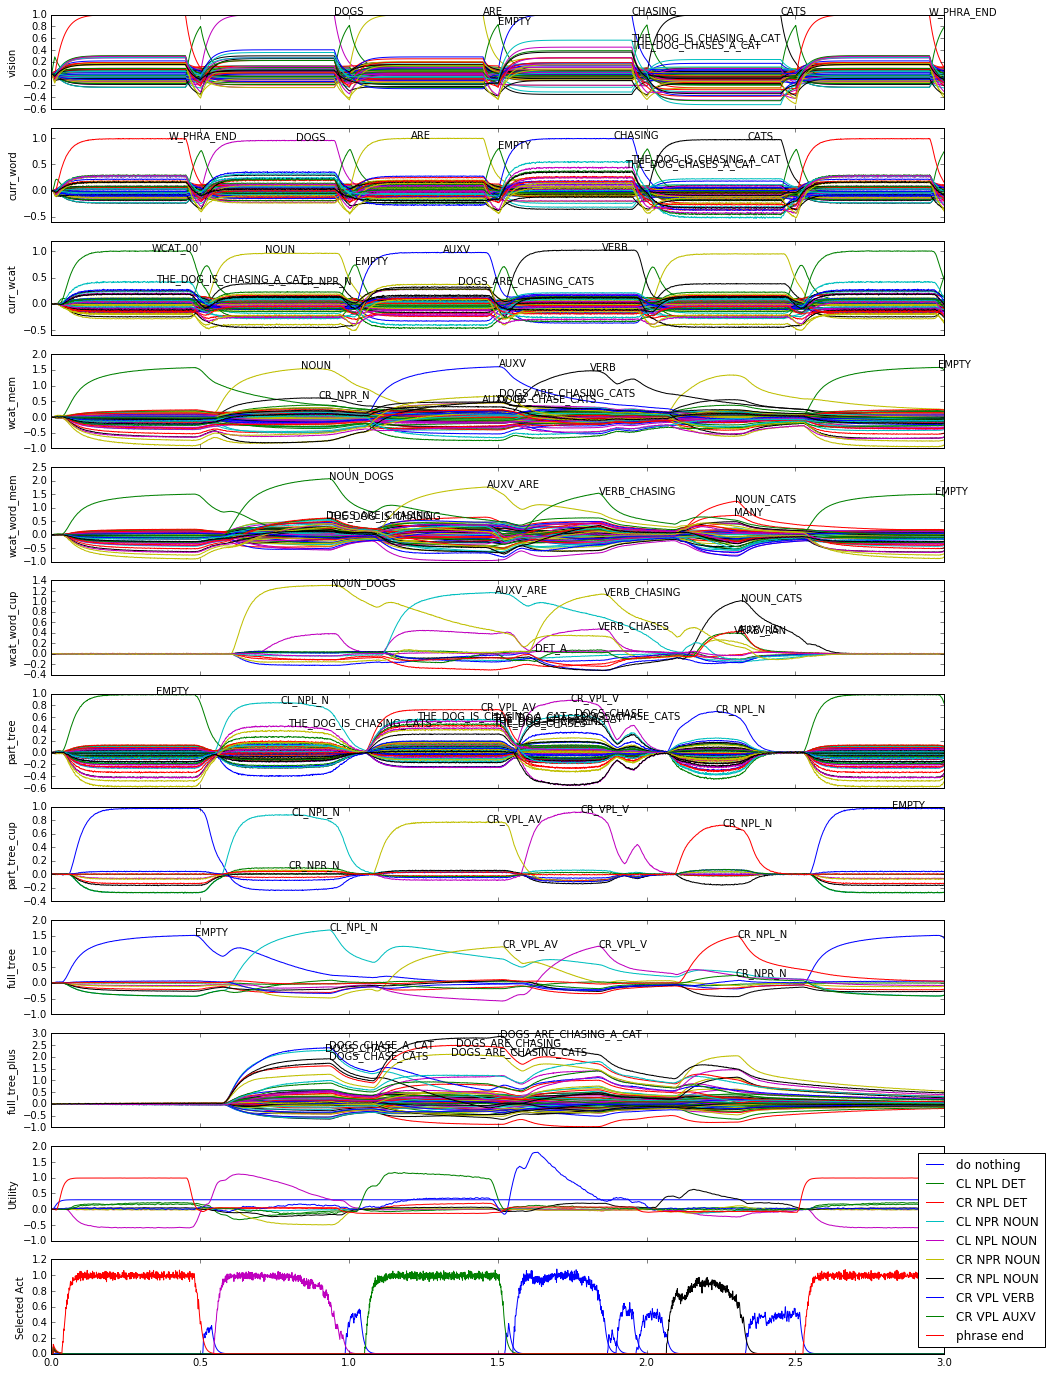

In [10]:
# plot the results 
fig, ax = plt.subplots(12, 1, sharex=True, figsize=(16,24))   # (x,y) 

nmax = 8
ax[0].plot(sim.trange(), spa.similarity(sim.data[p_vision], vocab_ex))
keys0 = list(vocab_ex.keys())
vision_simdata = np.asarray(spa.similarity(sim.data[p_vision], vocab_ex))
ax[0].set_ylabel('vision')
splist_tmax, splist_ymax, splist_name = most_active_SPs(keys0, nmax, vision_simdata)
for i in range(0,nmax):
    ax[0].text(splist_tmax[i], splist_ymax[i], splist_name[i])

nmax = 8
ax[1].plot(sim.trange(), spa.similarity(sim.data[p_curr_word], vocab_ex))
keys1 = list(vocab_ex.keys())
curr_word_simdata = np.asarray(spa.similarity(sim.data[p_curr_word], vocab_ex))
ax[1].set_ylabel('curr_word')
splist_tmax, splist_ymax, splist_name = most_active_SPs(keys1, nmax, curr_word_simdata)
for i in range(0,nmax):
    ax[1].text(splist_tmax[i], splist_ymax[i], splist_name[i])

nmax = 8
ax[2].plot(sim.trange(), spa.similarity(sim.data[p_curr_wcat], vocab_ex))
keys2 = list(vocab_ex.keys())
curr_wcat_simdata = np.asarray(spa.similarity(sim.data[p_curr_wcat], vocab_ex))
ax[2].set_ylabel('curr_wcat')
splist_tmax, splist_ymax, splist_name = most_active_SPs(keys2, nmax, curr_wcat_simdata)
for i in range(0,nmax):
    ax[2].text(splist_tmax[i], splist_ymax[i], splist_name[i])

nmax = 8
ax[3].plot(sim.trange(), spa.similarity(sim.data[p_wcat_mem], vocab_ex))
keys3 = list(vocab_ex.keys())
wcat_mem_simdata = np.asarray(spa.similarity(sim.data[p_wcat_mem], vocab_ex))
ax[3].set_ylabel('wcat_mem')
splist_tmax, splist_ymax, splist_name = most_active_SPs(keys3, nmax, wcat_mem_simdata)
for i in range(0,nmax):
    ax[3].text(splist_tmax[i], splist_ymax[i], splist_name[i])

nmax = 8
ax[4].plot(sim.trange(), spa.similarity(sim.data[p_wcat_word_mem], vocab_ex))
keys4 = list(vocab_ex.keys())
wcat_word_mem_simdata = np.asarray(spa.similarity(sim.data[p_wcat_word_mem], vocab_ex))
ax[4].set_ylabel('wcat_word_mem')
splist_tmax, splist_ymax, splist_name = most_active_SPs(keys4, nmax, wcat_word_mem_simdata)
for i in range(0,nmax):
    ax[4].text(splist_tmax[i], splist_ymax[i], splist_name[i])

nmax = 8
ax[5].plot(sim.trange(), spa.similarity(sim.data[p_wcat_word_cup], vocab_wcat_word))
keys5 = list(vocab_wcat_word.keys())
wcat_word_cup_simdata = np.asarray(spa.similarity(sim.data[p_wcat_word_cup], vocab_wcat_word))
ax[5].set_ylabel('wcat_word_cup')
splist_tmax, splist_ymax, splist_name = most_active_SPs(keys5, nmax, wcat_word_cup_simdata)
for i in range(0,nmax):
    ax[5].text(splist_tmax[i], splist_ymax[i], splist_name[i])

nmax = 12
ax[6].plot(sim.trange(), spa.similarity(sim.data[p_part_tree], vocab_ex))
keys6 = list(vocab_ex.keys())
part_tree_simdata = np.asarray(spa.similarity(sim.data[p_part_tree], vocab_ex))
ax[6].set_ylabel('part_tree')
splist_tmax, splist_ymax, splist_name = most_active_SPs(keys6, nmax, part_tree_simdata)
for i in range(0,nmax):
    ax[6].text(splist_tmax[i], splist_ymax[i], splist_name[i])

nmax = 6
ax[7].plot(sim.trange(), spa.similarity(sim.data[p_part_tree_cup], vocab_part_tree))
keys7 = list(vocab_part_tree.keys())
part_tree_cup_simdata = np.asarray(spa.similarity(sim.data[p_part_tree_cup], vocab_part_tree))
ax[7].set_ylabel('part_tree_cup')
splist_tmax, splist_ymax, splist_name = most_active_SPs(keys7, nmax, part_tree_cup_simdata)
for i in range(0,nmax):
    ax[7].text(splist_tmax[i], splist_ymax[i], splist_name[i])
    
nmax = 6
ax[8].plot(sim.trange(), spa.similarity(sim.data[p_full_tree], vocab_part_tree))
keys8 = list(vocab_part_tree.keys())
full_tree_simdata = np.asarray(spa.similarity(sim.data[p_full_tree], vocab_part_tree))
ax[8].set_ylabel('full_tree')
splist_tmax, splist_ymax, splist_name = most_active_SPs(keys8, nmax, full_tree_simdata)
for i in range(0,nmax):
    ax[8].text(splist_tmax[i], splist_ymax[i], splist_name[i])

nmax = 6
ax[9].plot(sim.trange(), spa.similarity(sim.data[p_full_tree_plus], vocab_ex))
keys9 = list(vocab_ex.keys())
full_tree_plus_simdata = np.asarray(spa.similarity(sim.data[p_full_tree_plus], vocab_ex))
ax[9].set_ylabel('full_tree_plus')
splist_tmax, splist_ymax, splist_name = most_active_SPs(keys9, nmax, full_tree_plus_simdata)
for i in range(0,nmax):
    ax[9].text(splist_tmax[i], splist_ymax[i], splist_name[i])

ax[10].plot(sim.trange(), sim.data[p_utility])
ax[10].set_ylabel('Utility')

ax[11].plot(sim.trange(), sim.data[p_selected_actions])
ax[11].legend(tuple(action_sel.keys()), loc='right', bbox_to_anchor=(1.12, 1.1))
ax[11].set_ylabel('Selected Act')
